# ***Image generation of FASHION-MNIST via β-VAE***

#**Theory**

**Encoder and decoder of VAE are decoded as follows.**
- Encoder (Gaussian distribution)：$$q_{\phi}({\bf z}|{\bf x}) = {\mathcal N}({\bf z}| \mu,\sigma^2{\bf I}), 　s.t.　\mu=g^{\mu}_{\phi}({\bf x}), \sigma=g^{\sigma}_{\phi}({\bf x}). $$
- Decoder (Bernoulli distribution)：$$p_{\theta}({\bf x}|{\bf z}) = Ber({\bf x}| \lambda), 　s.t.　\lambda=f_{\theta}({\bf z}).$$
<br>

**ELBO (Evidence Lower BOund) is represented like below.**  The first and the second term are corresponding to (minus) reconstruction loss and KL divergence, respectively. For the implementation of β-VAE, the coefficient β(>1) in the regularisation term of the objective function is needed in order to make the model more disentangled.


$$
 {\mathcal L}({\bf x};{\bf \theta},{\bf \phi}) = \mathbb{E}_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})] -\beta D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})]
 $$  

#**MODEL**

100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 5.22MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 57.5MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.3MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Epoch [1/10], Loss: 15847.9251
Epoch [2/10], Loss: 15501.8200
Epoch [3/10], Loss: 15427.3740
Epoch [4/10], Loss: 15388.6210
Epoch [5/10], Loss: 15370.1606
Epoch [6/10], Loss: 15357.2321
Epoch [7/10], Loss: 15346.2138
Epoch [8/10], Loss: 15339.1754
Epoch [9/10], Loss: 15332.6883
Epoch [10/10], Loss: 15327.6940


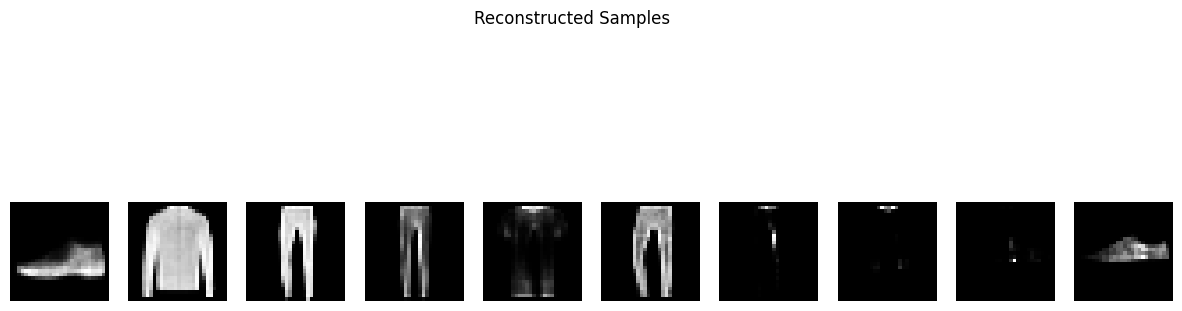

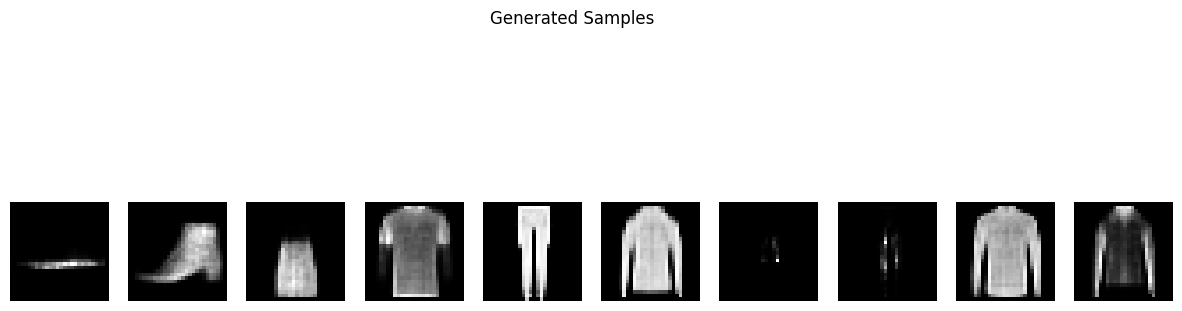

Visual analysis can help evaluate the VAE's capability for reconstruction and generation.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        latent_dim = 10
        encoded = self.encoder(x)
        mu, log_var = encoded[:, :latent_dim], encoded[:, latent_dim:]

        z = self.reparameterize(mu, log_var)

        recon_x = self.decoder(z)
        return recon_x, mu, log_var

def vae_loss(recon_x, x, mu, log_var, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kl_div


device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = VAE(latent_dim=10).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
epochs = 10
beta = 1.0

for epoch in range(epochs):
    vae.train()
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_data, mu, log_var = vae(data)
        loss = vae_loss(recon_data, data, mu, log_var, beta)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        torch.cuda.empty_cache()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss / len(train_loader):.4f}')

vae.eval()
with torch.no_grad():

    random_latent_vectors = torch.randn(100, 10).to(device)
    generated_samples = vae.decoder(random_latent_vectors).cpu()


    test_samples, _ = next(iter(test_loader))
    test_samples = test_samples.to(device)
    recon_samples, _, _ = vae(test_samples)


    fig, axes = plt.subplots(1, 10, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(recon_samples[i].cpu().squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle('Reconstructed Samples')
    plt.show()


    fig, axes = plt.subplots(1, 10, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(generated_samples[i].cpu().squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle('Generated Samples')
    plt.show()

print("Visual analysis can help evaluate the VAE's capability for reconstruction and generation.")


In [3]:
import torch
import numpy as np
from scipy.linalg import sqrtm
import torch.nn.functional as F
from torchvision.transforms import Resize


def preprocess_images(images, target_size=(75, 75)):
    """Resize and ensure images are 3-channel (RGB)."""
    images_resized = F.interpolate(images, size=target_size, mode='bilinear', align_corners=False)
    if images_resized.size(1) != 3:
        images_resized = images_resized.expand(-1, 3, -1, -1)
    return images_resized


def get_inception_features(images, model, device):
    """Extract features using Inception v3."""
    model.eval()
    with torch.no_grad():
        images = preprocess_images(images).to(device)
        features = model(images)
        features = features.view(features.size(0), -1)
    return features


def calculate_fid(real_images, generated_images, model, device):
    """Calculate FID score."""
    real_features = get_inception_features(real_images, model, device)
    generated_features = get_inception_features(generated_images, model, device)

    mu_real = torch.mean(real_features, dim=0)
    sigma_real = torch.cov(real_features.T)
    mu_generated = torch.mean(generated_features, dim=0)
    sigma_generated = torch.cov(generated_features.T)


    ssd = torch.sum((mu_real - mu_generated) ** 2)
    cov_sqrt = sqrtm((sigma_real @ sigma_generated).cpu().numpy())
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    cov_sqrt = torch.tensor(cov_sqrt, dtype=torch.float32, device=device)

    fid = ssd + torch.trace(sigma_real + sigma_generated - 2 * cov_sqrt)
    return fid.item()



from torchvision.models import inception_v3

inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model = inception_model.to(device)
inception_model.eval()

test_samples, _ = next(iter(test_loader))
test_samples = test_samples.to(device)
recon_samples, _, _ = vae(test_samples)
recon_samples = recon_samples.detach()

fid_reconstruction = calculate_fid(test_samples.cpu(), recon_samples.cpu(), inception_model, device)
print(f'FID between test samples and reconstructed samples: {fid_reconstruction:.4f}')


FID between test samples and reconstructed samples: 522.0016


پ)


توضیح در مورد لایه ConvTranspose2d در مدل VAE

لایه ConvTranspose2d (یا Transposed Convolution) یک لایه مهم در شبکه‌های عصبی برای آپ‌سمپلینگ (Upsampling) داده‌ها است. این لایه بر خلاف لایه معمولی Conv2d عمل می‌کند، که معمولاً برای کاهش ابعاد استفاده می‌شود. در ConvTranspose2d، هدف افزایش ابعاد داده است، که برای بازسازی تصویر در Decoder مدل‌هایی مانند VAE یا GAN استفاده می‌شود.
نحوه عملکرد ConvTranspose2d

ConvTranspose2d با استفاده از فیلترها و stride، مقادیر موجود در یک ورودی را به فضای بزرگ‌تر گسترش می‌دهد. این فرآیند شامل موارد زیر است:

    اعمال کرنل‌ها: هر پچ از داده ورودی با کرنل تطبیق داده شده و گسترش می‌یابد.
    stride: تعیین می‌کند که هر عنصر ورودی چقدر باید جابه‌جا شود تا خروجی بزرگ‌تر تولید شود.
    padding: پیکسل‌های اضافی به ورودی اضافه می‌شوند تا کنترل بیشتری روی ابعاد خروجی داشته باشیم.
    output_padding: این پارامتر برای تنظیم دقیق ابعاد خروجی استفاده می‌شود تا ابعاد موردنظر دقیقاً به‌دست بیاید.

رابطه ریاضی برای محاسبه ابعاد خروجی

فرمول محاسبه ابعاد خروجی در ConvTranspose2d به شرح زیر است:
Hout=(Hin−1)×S−2P+K+output_padding
Wout​=(Win​−1)×S−2P+K+output_padding

    Hout,WoutHout​,Wout​: ارتفاع و عرض خروجی
    Hin,WinHin​,Win​: ارتفاع و عرض ورودی
    SS: stride (گام جابه‌جایی کرنل)
    PP: padding (پد اضافه‌شده به ورودی)
    KK: اندازه کرنل (kernel size)
    output_padding: مقدار خروجی اضافی (معمولاً برای رسیدن به ابعاد خاص)
    نقش ConvTranspose2d در مدل

این لایه‌ها در Decoder مدل VAE برای بازسازی تصاویر MNIST به ابعاد اصلی (1,28,28)(1,28,28) استفاده می‌شوند. هر لایه به تدریج ابعاد داده را افزایش داده تا به تصویر اولیه نزدیک‌تر شود

ج)

مقدار 1.0 برای β یک انتخاب رایج است که برای تراز بین خطای بازسازی و ترجیحات KL Divergence مناسب است.
 تعداد 10 اپوک معمولاً برای شروع مناسب است و می‌تواند بر اساس معیارهایی مانند کاهش خطای آموزش یا نوسانات آن تغییر یابد.
  مقدار 0.001 معمولاً برای الگوریتم بهینه‌سازی Adam مقدار خوبی است و در بسیاری از مسائل کاربرد دارد. این انتخاب می‌تواند با آزمایش مقادیر مختلف مانند 0.01، 0.0001 و غیره بهینه‌سازی شود تا بهترین عملکرد را پیدا کند.

د)

تصاویر بازسازی‌شده:

    انتظار داریم تصاویر بازسازی‌شده شباهت بالایی به تصاویر اصلی داشته باشند.
    ممکن است جزئیات ریز حذف یا به‌صورت ساده‌سازی‌شده نمایش داده شوند، زیرا VAE تمایل به یادگیری نمایش فشرده دارد.

تصاویر تولیدشده:

    تصاویر تولیدشده کاملاً جدید هستند و معمولاً ترکیبی از ویژگی‌های کلی داده‌های آموزشی را نشان می‌دهند.
    ممکن است برخی تصاویر غیرواقعی یا ناواضح باشند، به‌ویژه اگر مدل به‌خوبی آموزش ندیده باشد یا ابعاد فضای نهفته نامناسب باشند

ر)

نحوه محاسبه FID:

    محاسبه ویژگی‌ها با استفاده از Inception v3:
        تصاویر واقعی و تولید شده به یک مدل Inception v3 داده می‌شوند تا ویژگی‌های استخراج شده از لایه‌های میانی (به‌ویژه لایه‌های پیشرفته) برای هر تصویر محاسبه شود.
        این ویژگی‌ها به عنوان بردارهای ویژگی برای هر تصویر در نظر گرفته می‌شوند.

    محاسبه میانگین و کوواریانس:
        برای هر مجموعه ویژگی‌ها (ویژگی‌های تصاویر واقعی و تولید شده)، میانگین و ماتریس کوواریانس محاسبه می‌شود.

    محاسبه فاصله Fréchet:
        فاصله Fréchet بین دو توزیع گوسی محاسبه می‌شود که در آن میانگین‌ها و ماتریس‌های کوواریانس ویژگی‌ها به‌کار می‌روند.
        فرمول FID به صورت زیر است:
        FID=∥μ1−μ2∥2+Tr(Σ1+Σ2−2(Σ1Σ2)1/2)
        FID=∥μ1​−μ2​∥2+Tr(Σ1​+Σ2​−2(Σ1​Σ2​)1/2) که در آن:
            μ1μ1​ و μ2μ2​ میانگین‌های بردار ویژگی‌های تصاویر واقعی و تولید شده هستند.
            Σ1Σ1​ و Σ2Σ2​ ماتریس‌های کوواریانس این ویژگی‌ها هستند.
            TrTr عملگر رد (tracing) ماتریس است.

  کاربرد FID در مدل‌های VAE:

مدل Variational Autoencoder (VAE) می‌تواند برای تولید تصاویر استفاده شود، و FID می‌تواند برای ارزیابی کیفیت این تصاویر به‌کار رود. مدل‌های VAE معمولاً به دلیل محدودیت‌هایی که در طراحی دارند (مانند استفاده از فضای نهفته) ممکن است تصاویر تولید شده کیفیت کمتری نسبت به مدل‌های GAN داشته باشند. به همین دلیل، FID می‌تواند نشان دهد که مدل VAE چقدر در تولید تصاویر با کیفیت بالا موفق بوده است.

و)

. معیار FID (Fréchet Inception Distance)

    تعریف: FID فاصله‌ای بین دو توزیع ویژگی‌های استخراج‌شده از تصاویر واقعی و تولید شده است. این معیار از مدل Inception Network برای استخراج ویژگی‌ها استفاده می‌کند.
    چگونگی کارکرد: برای محاسبه FID، ویژگی‌های تصاویر واقعی و تولید شده با استفاده از لایه‌های میانه مدل Inception استخراج می‌شوند و سپس فاصله Fréchet بین دو توزیع نرمال (ویژگی‌ها) محاسبه می‌شود.
    مفید بودن: FID معیاری بسیار محبوب برای سنجش کیفیت تصاویر تولید شده است و معمولاً برای مقایسه مدل‌ها با یکدیگر مورد استفاده قرار می‌گیرد. مقادیر پایین‌تر FID نشان‌دهنده کیفیت بهتر تصاویر تولید شده است.
    مزایا: FID می‌تواند تفاوت‌های پیچیده بین توزیع‌های تصاویر واقعی و تولیدی را نشان دهد و نسبت به معیارهایی مانند IS حساس‌تر است.

2. معیار IS (Inception Score)

    تعریف: IS از مدل Inception Network برای محاسبه پیچیدگی و تنوع تصاویر تولید شده استفاده می‌کند. این معیار بررسی می‌کند که آیا تصاویر تولید شده قابل تشخیص هستند و به دسته‌بندی‌های خاصی تعلق دارند.
    چگونگی کارکرد: IS بر اساس خروجی نرم‌افزار مدل Inception محاسبه می‌شود و برای هر تصویر، مقدار احتمال تعلق به هر کلاس را بررسی می‌کند. سپس انواع و پایداری این احتمال‌ها برای محاسبه IS مورد استفاده قرار می‌گیرد.
    مفید بودن: IS نشان‌دهنده تنوع و کیفیت کلی تصاویر تولیدی است. مقادیر بالاتر IS نشان‌دهنده کیفیت بهتر و تنوع بیشتر تصاویر تولید شده است.
    محدودیت‌ها: IS در برخی موارد می‌تواند اطلاعات کمی در مورد فاصله بین توزیع‌ها بدهد و ممکن است برای مقایسه مدل‌ها در شرایط مختلف ناپایدار باشد.

3. مزایا و معایب مقایسه FID و IS

    FID:
        مزایا: به دلیل استفاده از فاصله Fréchet، FID دقیق‌تر و حساس‌تر به تفاوت‌های بین تصاویر واقعی و تولید شده است. همچنین، می‌تواند اطلاعاتی در مورد کیفیت تصاویر و هم‌ترازی توزیع‌ها بدهد.
        معایب: برای محاسبه FID نیاز به مدل Inception پیش‌آموزش دیده شده دارید و این ممکن است محدودیت‌هایی از نظر سخت‌افزار و زمان محاسبه داشته باشد.
    IS:
        مزایا: ساده‌تر است و می‌تواند برای ارزیابی اولیه مدل‌ها استفاده شود. همچنین به راحتی قابل پیاده‌سازی است.
        معایب: ممکن است ناپایدار باشد و اطلاعات محدودی در مورد فاصله واقعی بین توزیع‌ها بدهد. همچنین، ممکن است در ارزیابی مدل‌هایی با کیفیت پایین و کمبود تنوع، نتایج قابل اعتمادی ارائه ندهد.

4. معیارهای دیگر

برای ارزیابی مدل‌های VAE می‌توان از معیارهای دیگری مانند:

    Perceptual Loss: بررسی شباهت بصری بین تصاویر واقعی و تولید شده با استفاده از شبکه‌های عصبی عمیق.
    LPIPS (Learned Perceptual Image Patch Similarity): معیار دیگری برای سنجش کیفیت بصری که حساسیت بیشتری نسبت به تغییرات کوچک در تصاویر دارد.